# Лабораторная работа 2

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков Jupyter (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий, а также подкреплённый грамотной визуализацией. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета, кода и графиков. 

## Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 20 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают свою карму
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому, чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

## Прорабатываемые темы
  * Деревья
  * Лес
  * Бустинг

## Данные

Из официального блога Яндекса [известно,](https://yandex.ru/blog/company/meteum-2-0-ili-pochemu-yandeks-pogoda-sprashivaet-vas-o-dozhde) что технология предсказания погоды Метеум 2.0 опирается на Catboost.

Там же говорится, о том, что в качестве признаков используются данные от метеомоделей и дополнительные признаки, например, ```высота солнца над горизонтом``` или ```удалённость от водоёма```.




Этим летом Яндекс выложил в свободный доступ погодный датасет. В данной лабораторной работе мы будем пытаться сделать свой прогноз погоды, основываясь на этих данных.

Лицензия на данные доступна [тут](https://github.com/yandex-research/shifts#license).

### Метеомодели
Что из себя представляет прогноз метеомодели?
Фактически, это четырёхмерный тензор.
  * Две компоненты -- это широта и долгота. У каждого поставщика прогнозов свои шаги сетки по широте и долготе;
  * Вырожденное измерение, которое содержит только одно значение -- время начального состояния атмосферы, с которого будет начато физическое моделирование;
  * Последнее измерение - время, на которое сделан прогноз. Каждый поставщик таже имеет свои сетки, но обычно не чаще одного прогноза в час.
    
Для хранения таких данных был разработан формат файлов https://en.wikipedia.org/wiki/GRIB

Например, такие данные для модели GFS можно скачать с сайта https://www.ncei.noaa.gov/products/weather-climate-models/global-forecast



### Признаки
Из первых уст про признаки можно узнать из [видео Лены Волжиной.](https://youtu.be/ECALEJ79KHg?t=578)

Их источники можно разделить на следующие группы
  * Прогноз глобальных метеомоделей. В выгруженных данных это модели CMC и GFS
    * признаки, которые начинаются с ```cmc_```
    * признаки, которые начинаются с ```gfs_```
  * Прогнозы от региональной модели WRF
    * признаки, которые начинаются с ```wrf_```
  * Климатические данные (за 40 лет наблюдений)
    * признаки, которые начинаются с ```climate_```
  * Прочие признаки
    * 'sun_elevation' -- та самая высота солнца над горизонтом.
    * 'topography_bathymetry' 
  
  
Признаки cmc имеют в своём имени 4 числа, которые кодируют физическую величину. Последнее значение -- это высота, на которой величина вычислена.

Признаки gfs и wrf имеют человеко-читаемые названия.

Еще есть технические атрибуты прогноза поставщика:
  * `_available` -- был ли доступен поставщик при прогнозе
  * ```_horizon_h``` -- каковым горизонтом для модели поставщика была временная отметка, на которую meteum рассчитвал прогноз.

  * ```_next``` -- это значение следущего прогноза данного поставщика для данной точки.

Кроме того, есть еще признаки, комбинирующие выше описанные, например
  * _grad -- это разница разница между обычным и _next прогнозом температуры.


Вот рисунок, который поможет разобраться с этими терминами:
<img src="images/object_structure.jpg">

### Целевые переменные
  * fact_temperature -- температура в данной точке (точка описывается парой координат 'fact_latitude', 'fact_longitude'  и временной отметкой 'fact_time' )
  * fact_cwsm_class -- код облачности и осадков
<img src="./images/cwsm_classes.jpg">

### Факты
  Источником истинных меток  в задачах прогнозирования погоды служат данные с метеостанций. Каждая метеостанция имеет свои географические кординаты, а также свою частоту, с которой она замеряет погоду. Некоторые метеостанции замеряют ее лишь 8 раз в день при помощи специалистов-метеорологов. Некоторые являются автоматическими и имеют большую частоту потока фактических показателей.

### Как был собран dataset
Каждое из фактических предсказаний могло быть предсказано с разными заблаговременностями.

Было составлено декартово произведение следующих множеств (см. рисунок выше)
  * (время факта, координата факта) 
  * (время составления прогноза) 
  * (самый свежий прогноз от поставщика, доступный к моменту составления прогноза на время, ближайшее ко времени факта)
    
Оно было равномерно просемлировано, чтобы его размер стал обозримым.




## Знакомство с данными

Для уменьшения количества данных, возьмем только кусок за сентябрь 2018 года

In [2]:
path_csv_2018_09 = 'data_2/train_2018_09.csv'
path_csv_2018_10 = 'data_2/train_2018_10.csv'
path_csv_2018_11 = 'data_2/train_2018_11.csv'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
drive_path = '/content/drive/MyDrive/Shad/2021ml/lab2/'

In [6]:
train_2018_09 = pd.read_csv(drive_path + path_csv_2018_09)
train_2018_10 = pd.read_csv(drive_path + path_csv_2018_10)
train_2018_11 = pd.read_csv(drive_path + path_csv_2018_11)

In [7]:
fact_columns = [
 'fact_time',
 'fact_latitude',
 'fact_longitude',
 'fact_temperature',
 'fact_cwsm_class'
]

In [8]:
other_columns = [
 'topography_bathymetry',
 'sun_elevation',
]

climate_columns = [
 'climate_temperature',
 'climate_pressure',
]

climat_zone_column = 'climate'

In [9]:
cmc_columns = [
 'cmc_0_0_0_1000',
 'cmc_0_0_0_2_grad',
 'cmc_0_0_0_2_interpolated',
 'cmc_0_0_0_2_next',
 'cmc_0_0_0_2',
 'cmc_0_0_0_500',
 'cmc_0_0_0_700',
 'cmc_0_0_0_850',
 'cmc_0_0_0_925',
 'cmc_0_0_6_2',
 'cmc_0_0_7_1000',
 'cmc_0_0_7_2',
 'cmc_0_0_7_500',
 'cmc_0_0_7_700',
 'cmc_0_0_7_850',
 'cmc_0_0_7_925',
 'cmc_0_1_0_0',
 'cmc_0_1_11_0',
 'cmc_0_1_65_0',
 'cmc_0_1_66_0',
 'cmc_0_1_67_0',
 'cmc_0_1_68_0',
 'cmc_0_1_7_0',
 'cmc_0_2_2_10',
 'cmc_0_2_2_1000',
 'cmc_0_2_2_500',
 'cmc_0_2_2_700',
 'cmc_0_2_2_850',
 'cmc_0_2_2_925',
 'cmc_0_2_3_10',
 'cmc_0_2_3_1000',
 'cmc_0_2_3_500',
 'cmc_0_2_3_700',
 'cmc_0_2_3_850',
 'cmc_0_2_3_925',
 'cmc_0_3_0_0',
 'cmc_0_3_0_0_next',
 'cmc_0_3_1_0',
 'cmc_0_3_5_1000',
 'cmc_0_3_5_500',
 'cmc_0_3_5_700',
 'cmc_0_3_5_850',
 'cmc_0_3_5_925',
 'cmc_0_6_1_0',
 'cmc_available',
 'cmc_horizon_h',
 'cmc_precipitations',
 'cmc_timedelta_s',
 'cmc_0_1_65_0_grad',
 'cmc_0_1_65_0_next',
 'cmc_0_1_66_0_grad',
 'cmc_0_1_66_0_next',
 'cmc_0_1_67_0_grad',
 'cmc_0_1_67_0_next',
 'cmc_0_1_68_0_grad',
 'cmc_0_1_68_0_next', 
]

In [10]:
gfs_columns = [
 'gfs_2m_dewpoint',
 'gfs_a_vorticity',
 'gfs_available',
 'gfs_cloudness',
 'gfs_clouds_sea',
 'gfs_horizon_h',
 'gfs_humidity',
 'gfs_precipitable_water',
 'gfs_precipitations',
 'gfs_pressure',
 'gfs_r_velocity',
 'gfs_soil_temperature',
 'gfs_soil_temperature_available',
 'gfs_temperature_10000',
 'gfs_temperature_15000',
 'gfs_temperature_20000',
 'gfs_temperature_25000',
 'gfs_temperature_30000',
 'gfs_temperature_35000',
 'gfs_temperature_40000',
 'gfs_temperature_45000',
 'gfs_temperature_5000',
 'gfs_temperature_50000',
 'gfs_temperature_55000',
 'gfs_temperature_60000',
 'gfs_temperature_65000',
 'gfs_temperature_7000',
 'gfs_temperature_70000',
 'gfs_temperature_75000',
 'gfs_temperature_80000',
 'gfs_temperature_85000',
 'gfs_temperature_90000',
 'gfs_temperature_92500',
 'gfs_temperature_95000',
 'gfs_temperature_97500',
 'gfs_temperature_sea',
 'gfs_temperature_sea_grad',
 'gfs_temperature_sea_interpolated',
 'gfs_temperature_sea_next',
 'gfs_timedelta_s',
 'gfs_total_clouds_cover_high',
 'gfs_total_clouds_cover_low',
 'gfs_total_clouds_cover_middle',
 'gfs_u_wind',
 'gfs_v_wind',
 'gfs_wind_speed',
 'gfs_2m_dewpoint_grad',
 'gfs_2m_dewpoint_next',
 'gfs_total_clouds_cover_low_grad',
 'gfs_total_clouds_cover_low_next'
]

In [11]:
wrf_columns = [
 'wrf_available',
 'wrf_t2',
 'wrf_t2_next',
 'wrf_psfc',
 'wrf_rh2',
 'wrf_wind_u',
 'wrf_wind_v',
 'wrf_rain',
 'wrf_snow',
 'wrf_graupel',
 'wrf_hail',
 'wrf_t2_interpolated',
 'wrf_t2_grad',
]

Мы будем рассматривать задачи двух типов
  * Задачу регрессии предсказания температуры (колонка fact_temperature)
  * Задачу классификации -- предсказание кода облачности и осадков (колонка fact_cwsm_class)  

Рассмотрим, как метки этих задач расположены на "карте мира":

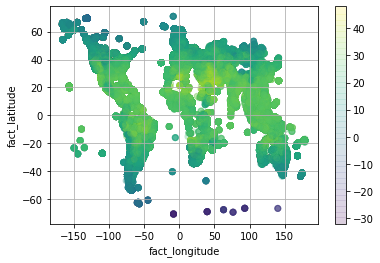

In [12]:
plt.scatter(
    train_2018_09.fact_longitude,
    train_2018_09.fact_latitude,
    c= train_2018_09.fact_temperature,
    alpha=0.1 
)
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

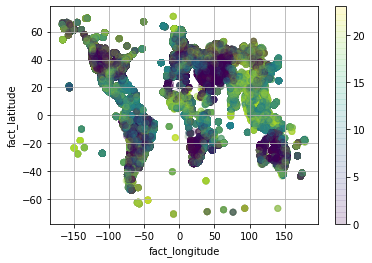

In [13]:
plt.scatter(
   train_2018_09.fact_longitude,
   train_2018_09.fact_latitude,
   c= train_2018_09.fact_cwsm_class,
   alpha=0.1 
)
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

### Задание 1. Исследование данных (1 балл)

Проведите исследовательский анализ данных.

Задача: понять взаимосвязи между откликами fact_temperature и fact_cwsm_class и признаками

In [14]:
train_2018_09.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,cmc_0_0_0_2_grad,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,cmc_0_0_0_500,cmc_0_0_0_700,cmc_0_0_0_850,cmc_0_0_0_925,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,cmc_0_0_7_500,cmc_0_0_7_700,cmc_0_0_7_850,cmc_0_0_7_925,cmc_0_1_0_0,cmc_0_1_11_0,cmc_0_1_65_0,cmc_0_1_66_0,cmc_0_1_67_0,cmc_0_1_68_0,cmc_0_1_7_0,cmc_0_2_2_10,cmc_0_2_2_1000,cmc_0_2_2_500,cmc_0_2_2_700,cmc_0_2_2_850,cmc_0_2_2_925,cmc_0_2_3_10,...,gfs_temperature_90000,gfs_temperature_92500,gfs_temperature_95000,gfs_temperature_97500,gfs_temperature_sea,gfs_temperature_sea_grad,gfs_temperature_sea_interpolated,gfs_temperature_sea_next,gfs_timedelta_s,gfs_total_clouds_cover_high,gfs_total_clouds_cover_low,gfs_total_clouds_cover_middle,gfs_u_wind,gfs_v_wind,gfs_wind_speed,wrf_available,wrf_t2,wrf_t2_next,wrf_psfc,wrf_rh2,wrf_wind_u,wrf_wind_v,wrf_rain,wrf_snow,wrf_graupel,wrf_hail,wrf_t2_interpolated,wrf_t2_grad,cmc_0_1_65_0_grad,cmc_0_1_65_0_next,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.535767e+09,25.267000,51.600000,33.0,0.0,dry,-1.0,-4.608248,32.076429,749.301627,304.669897,-0.277905,304.657772,304.565137,304.843042,269.020557,288.424268,302.584424,308.145923,295.596649,9.125,9.125,25.125000,16.625,29.250,25.500,0.0212,0.0,0.05800,0.0,0.0,0.0,0.000000,1.922366,1.869354,-11.265332,-6.395151,-2.818555,0.501080,1.404033,...,33.050012,34.041559,33.950006,33.850000,32.850000,0.200012,32.983341,33.050012,7200.0,1.0,0.0,0.0,-2.635000,-0.280691,2.649908,1.0,305.775513,305.605164,99897.765625,0.895239,-1.574223,3.837289,0.000008,0.000000,0.0,0.0,305.775513,-0.170349,0.000000,0.058000,0.0,0.0,0.0,0.0,0.0,0.0,-0.200012,22.950006,0.0,0.0
1,1.536397e+09,34.678699,-86.684799,22.0,0.0,mild temperate,193.0,-40.102271,23.099286,745.190286,296.940674,-0.406616,295.902922,295.767383,296.173999,266.795239,281.725220,291.316943,297.325171,293.480743,3.000,2.500,11.546477,7.375,3.125,6.500,0.0153,0.0,0.55817,0.0,0.0,0.0,0.000000,-1.990372,-2.058002,1.518396,1.948431,-0.586707,-0.722437,0.971790,...,22.330682,24.230676,25.582758,25.849969,23.363641,-0.913635,22.754551,22.450006,7200.0,30.0,0.0,0.0,-1.434629,0.914070,1.701083,1.0,294.964325,294.623871,99279.765625,0.972616,-2.254223,0.087720,0.000000,0.000000,0.0,0.0,294.964325,-0.340454,-0.000008,0.558163,0.0,0.0,0.0,0.0,0.0,0.0,-0.300018,19.249994,0.0,0.0
2,1.537358e+09,10.233333,77.466667,14.0,21.0,tropical,2230.0,12.304183,25.134286,687.545585,303.191797,-5.643262,300.435913,294.792651,300.435913,267.989062,282.763330,293.405859,299.000220,287.994812,13.500,12.375,7.069485,3.250,7.750,10.875,0.0115,0.0,0.66675,0.0,0.0,0.0,0.000000,1.979175,1.802510,9.175082,5.530981,3.516541,1.536279,-0.522395,...,22.450006,23.950006,25.449976,26.850000,18.650018,-1.600006,18.650018,17.050012,0.0,57.0,5.0,78.0,1.976752,-0.476173,2.033295,1.0,291.570374,290.430023,82000.289062,0.816018,3.006323,-1.915054,0.000000,0.000000,0.0,0.0,291.570374,-1.140350,0.000000,0.666750,0.0,0.0,0.0,0.0,0.0,0.0,-0.314789,16.735223,14.0,19.0
3,1.537045e+09,22.950399,120.206001,25.0,11.0,tropical,17.0,-13.024131,28.689286,765.703272,302.831030,-0.592078,302.624854,302.032776,302.624854,271.557031,284.846045,292.606982,297.885889,296.382294,6.375,6.125,0.821390,1.125,0.500,3.500,0.0178,0.0,0.41460,0.0,0.0,0.0,0.000000,-9.983542,-9.884790,-16.954218,-23.021951,-21.629657,-18.206097,4.455054,...,23.450006,25.249994,27.149988,29.088617,30.349969,0.600006,30.349969,30.949976,0.0,100.0,28.0,19.0,-7.247314,5.760730,9.257947,1.0,299.785797,299.845795,99986.421875,0.944857,-3.414961,10.845577,2.272505,0.000002,0.0,0.0,299.785797,0.059998,0.098400,0.513000,0.0,0.0,0.0,0.0,0.0,0.0,0.099976,23.249994,3.0,31.0
4,1.538317e+09,36.175301,-96.151802,2

*Посмотрим, как распределена температура в зависимости от широты (цветом обозначены осадки и подъём Солнца)*

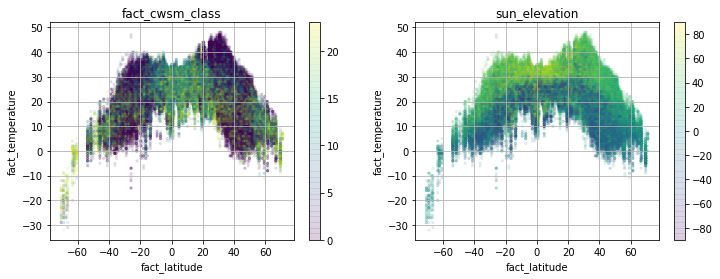

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    train_2018_09.fact_latitude, 
    train_2018_09.fact_temperature, 
    c=train_2018_09.fact_cwsm_class, 
    s=5, alpha=0.1
)
plt.title('fact_cwsm_class')
plt.xlabel("fact_latitude")
plt.ylabel("fact_temperature")

plt.colorbar()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(
    train_2018_09.fact_latitude, 
    train_2018_09.fact_temperature, 
    c=train_2018_09.sun_elevation, 
    s=5, alpha=0.1
)
plt.title('sun_elevation')
plt.xlabel("fact_latitude")
plt.ylabel("fact_temperature")

plt.colorbar()
plt.grid()

## Часть 1
Начнем с более простой задачи регрессии.

Как обычно, сначало вычислим набор тривиальных baseline решений.
Будем использовать 2 метрики качества
  * RMSE -- основная метрика
  * Долю отклонений от факта на 2 градуса -- вспомогательная метрика 

### Задание 2. Baseline решение (0.5 балла)

Построить baseline решения и вычислить метрики на периоде 2018_09:
 * климат (climate_temperature)
 * Предсказание поставщиков 
    * cmc
      * 'cmc_0_0_0_2_interpolated'
      * 'cmc_0_0_0_2_next'
      * 'cmc_0_0_0_2'
    * gfs
      * 'gfs_temperature_sea'
      * 'gfs_temperature_sea_interpolated'
      * 'gfs_temperature_sea_next'
    * wrf
      * 'wrf_t2'
      * 'wrf_t2_next'
      * 'wrf_t2_interpolated'
 * Dummy Classifier 
   * https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
     * обучать на 2018_09, тетсировать на 2018_10


In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPRegressor
train_x = train_2018_09[[
  'fact_time',
  'fact_latitude',
  'fact_longitude', 
  'topography_bathymetry',
  'sun_elevation',
  'climate_temperature'
]]
train_y = train_2018_09['fact_temperature']
test_x = train_2018_10[[
  'fact_time',
  'fact_latitude',
  'fact_longitude', 
  'topography_bathymetry',
  'sun_elevation',
  'climate_temperature'
]]
test_y = train_2018_10['fact_temperature']

model_dummy = DummyClassifier()
model_dummy.fit(train_x, train_y)
pred_y_dummy = model_dummy.predict(test_x)

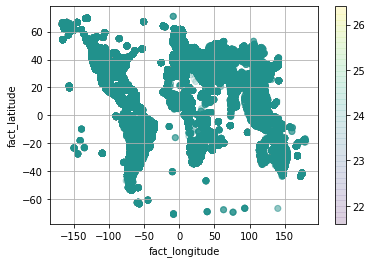

In [17]:
plt.figure(figsize=(6, 4))

plt.scatter(
    test_x.fact_longitude,
    test_x.fact_latitude,
    c= pred_y_dummy,
    alpha=0.1 
)
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

### Задание 3. Решающее дерево (0.5 балла) 

Подобрать лучшее дерево решений на валидации. Понять, сколько в нём листов, и как долго оно обучается.
  * обучающее множество пусть будет 2018_09, а валидационное -- 2018_10

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth': [2, 3, 5, 10], 'min_samples_leaf': [1, 3, 7, 20]}]
searcher = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
searcher.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [2, 3, 5, 10],
                          'min_samples_leaf': [1, 3, 7, 20]}])

In [19]:
print (searcher.best_estimator_, searcher.best_score_)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=3) 0.8010318856136713


In [20]:
%%time
model_dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=3)
model_dt.fit(train_x, train_y)

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.87 s


In [58]:
model_dt.n_features_in_

6

### Задание 4. Строим ансамбли (2 балл) 

Обучить случайный лес [RF] и Extremely Randomized Trees [ERT] (см. тут: https://scikit-learn.org/stable/modules/ensemble.html ) с параметрами, лучшими для одиночного дерева решений (по глубине и прочим параметрам, которые вы варьировали в прошлом задании) и сравнить с моделями Extremely Randomized Tree и случайным лесом с дефолтными параметрами.

Число деревьев в ансамбле возьмите для обоих сценариев равным 20. Замерьте время, потраченное на обучение.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor

In [22]:
%%time
model_rf = RandomForestRegressor(criterion='squared_error', n_estimators=20, max_depth=10, min_samples_leaf=3)
model_rf.fit(train_x, train_y)

CPU times: user 44.1 s, sys: 34.9 ms, total: 44.1 s
Wall time: 47.2 s


In [23]:
%%time
model_ert = ExtraTreeRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=3)
model_ert.fit(train_x, train_y)

CPU times: user 422 ms, sys: 2.5 ms, total: 424 ms
Wall time: 424 ms


In [24]:
model_rf_default = RandomForestRegressor(criterion='squared_error', n_estimators=20)
model_ert_default = ExtraTreeRegressor(criterion='squared_error')
model_rf_default.fit(train_x, train_y)
model_ert_default.fit(train_x, train_y)

ExtraTreeRegressor()

In [25]:
pred_y_rf = model_rf.predict(test_x)
pred_y_ert = model_ert.predict(test_x)

pred_y_rf_default = model_rf_default.predict(test_x)
pred_y_ert_default = model_ert_default.predict(test_x)

In [26]:
from sklearn.metrics import mean_squared_error
print('RMSE rf: ', mean_squared_error(test_y, pred_y_rf))
print('RMSE ert: ', mean_squared_error(test_y, pred_y_ert))
print('RMSE rf default: ', mean_squared_error(test_y, pred_y_rf_default))
print('RMSE ert default: ', mean_squared_error(test_y, pred_y_ert_default))

RMSE rf:  19.840979304051597
RMSE ert:  21.203974788829303
RMSE rf default:  21.605786191049965
RMSE ert default:  30.320011868145805


*Time: 31 s, 244ms; RMSE: 19.9, 20.5*  

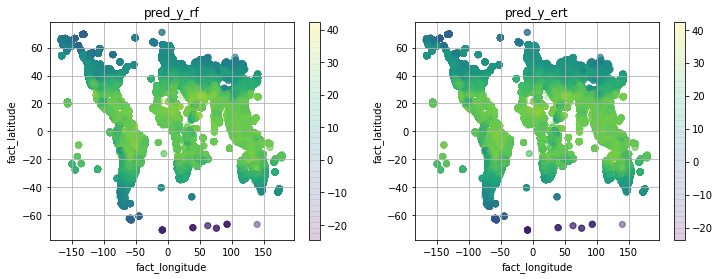

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(
    test_x.fact_longitude,
    test_x.fact_latitude,
    c= pred_y_rf,
    alpha=0.1 
)
plt.title('pred_y_rf')
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(
    test_x.fact_longitude,
    test_x.fact_latitude,
    c= pred_y_ert,
    alpha=0.1 
)
plt.title('pred_y_ert')
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

plt.show()

### Задание 5. Квантизация признаков (1 балл) 

Давайте загрубим (квантизуем) признаки, чтобы алгоритмам построения дерева перебирать меньше порогов.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer

Еще раз обучим модели из предыдущего задания и посмотрим, насколько изменяется время.

Начинайте с более агрессивных квантизаций: т.е. сильно загрубляйте исходный признак.

In [28]:
from sklearn.preprocessing import KBinsDiscretizer
kbd = KBinsDiscretizer(n_bins=40, encode='ordinal')


In [29]:
kbd.fit(train_x)
train_x_discretized = pd.DataFrame(kbd.transform(train_x), columns=train_x.columns)
kbd.fit(test_x)
test_x_discretized = pd.DataFrame(kbd.transform(test_x), columns=test_x.columns)

In [30]:
%%time
model_rf_discretized = RandomForestRegressor(criterion='squared_error', n_estimators=20, max_depth=10, min_samples_leaf=3)
model_rf_discretized.fit(train_x_discretized, train_y)

CPU times: user 18.5 s, sys: 9.26 ms, total: 18.5 s
Wall time: 18.4 s


In [31]:
%%time
model_ert_discretized = ExtraTreeRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=3)
model_ert_discretized.fit(train_x_discretized, train_y)

CPU times: user 492 ms, sys: 521 µs, total: 493 ms
Wall time: 488 ms


In [32]:
pred_y_rf_discretized = model_rf.predict(test_x_discretized)
pred_y_ert_discretized = model_ert.predict(test_x_discretized)

In [33]:
print('RMSE rf discretized: ', mean_squared_error(test_y, pred_y_rf_discretized))
print('RMSE ert discretized: ', mean_squared_error(test_y, pred_y_ert_discretized))

RMSE rf discretized:  41.51553554618086
RMSE ert discretized:  39.95400067096548


*В зависимости от количества бинов время и ошибка меняются вот так*

*n_bins: 3 -> Time: 3.9 s, 196 ms; RMSE: 409, 269*  
*n_bins: 10 -> Time: 7.7 s, 257 ms; RMSE: 226, 188*  
*n_bins: 30 -> Time: 11 s, 272 ms; RMSE: 35, 33*  
*n_bins: 35 -> Time: 11 s, 248 ms; RMSE: 31, 30*  
*n_bins: 50 -> Time: 13 s, 257 ms; RMSE: 100, 100*  
*n_bins: 100 -> Time: 15 s, 325 ms; RMSE: 290, 309*  
*n_bins: 200 -> Time: 16 s, 270 ms; RMSE: 396, 376*  


*При увеличении количества бинов растёт время обучения RF. RMSE сначала падает, но при больших n_bins начинает расти. Наверное, потому что размеры бинов становятся слишком маленькими.*

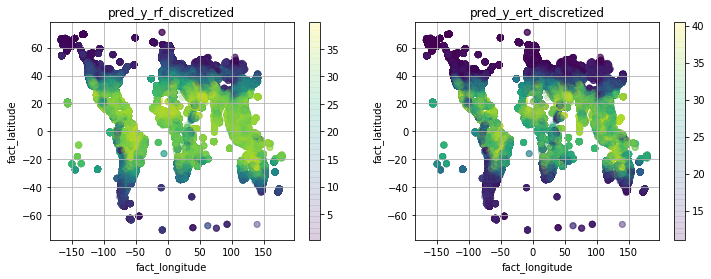

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(
    test_x.fact_longitude,
    test_x.fact_latitude,
    c= pred_y_rf_discretized,
    alpha=0.1 
)
plt.title('pred_y_rf_discretized')
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(
    test_x.fact_longitude,
    test_x.fact_latitude,
    c= pred_y_ert_discretized,
    alpha=0.1 
)
plt.title('pred_y_ert_discretized')
plt.ylabel("fact_latitude")
plt.xlabel("fact_longitude")
plt.colorbar()
plt.grid()

plt.show()

### Задание 6 (0.5 балл) 
Катбуст умеет квантизовать признаки. Но как transformer в терминах sklearn он не функционирует.
Давайте напишем свой класс Трансформер, который будет
  * создавать cb.Pool
  * вызывать pool.quantize(border_count=32,feature_border_type="UniformAndQuantiles")  
  * сохранять pool.save_quantization_borders("borders.dat")
  * парсить этот файл, который имеет вполне прозрачную структуру
    * индекс признака, граница разбиения, возможно, указание, как быть в nan. 
  * при помощи np.digitize производить квантизацию


https://catboost.ai/en/docs/concepts/quantization

In [35]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 52 kB/s 


In [36]:
from catboost import Pool
import numpy as np

class Transformer:
    def __init__(self, data):
        self.pool = Pool(data)
    
    def quantize(self, border_count=32, feature_border_type="UniformAndQuantiles"):
        self.pool.quantize(border_count=border_count,feature_border_type=feature_border_type)

    def save(self, filename="borders.dat"):
        self.pool.save_quantization_borders(filename)

    def parse_file(self, filename="borders.dat"):
        self.borders = {}
        with open(filename) as f:
            for line in f:
                splitted = line.split()
                k, v = int(splitted[0]), float(splitted[1])
                if k not in self.borders:
                    self.borders[k] = []
                self.borders[k].append(v)
    
    def digitize(self, data):
        copy = data.copy()
        for k in self.borders:
            v = self.borders[k]
            copy.iloc[:, k] = np.digitize(copy.iloc[:, k], v)
        return copy

*Посмотрим, как работает*

In [37]:
transformer = Transformer(train_x)
transformer.quantize()
transformer.save()
transformer.parse_file()
transformer.digitize(train_x).head()

,fact_time,fact_latitude,fact_longitude,topography_bathymetry,sun_elevation,climate_temperature
0,0,15,23,6,15,29
1,8,20,7,15,6,20
2,20,11,25,26,18,22
3,16,15,30,9,13,26
4,32,22,6,16,19,12


### Задание 7 (1 балл) 
Подберите метод квантизации (в Catboost их несколько) и число border`ов , чтобы улучшить модели из Задания 4 (там мы учили случайные леса RF и Extremely Randomized Trees ERT ).

Произошло ли ускорение, за счет квантизации?

Можем ли мы позволить себе больше глубины в деревьях и число элеметнов в ансамбле? 

На какой итерации ансамбли перестают улчшаться на валидационной выборке?

In [38]:
import time

# quantization_methods = ['Median', 'Uniform', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy', 'GreedyLogSum']
quantization_methods = ['Uniform']
borders_numbers = [16, 32]

for qm in quantization_methods:
    for bn in borders_numbers:
        
        transformer = Transformer(train_x)
        transformer.quantize(bn, qm)
        transformer.save()
        transformer.parse_file()
        train_x_digitized = transformer.digitize(train_x)

        transformer = Transformer(test_x)
        transformer.quantize(bn, qm)
        transformer.save()
        transformer.parse_file()
        test_x_digitized = transformer.digitize(test_x)
        
        model_rf_q = RandomForestRegressor(criterion='squared_error', n_estimators=20, max_depth=10, min_samples_leaf=3)


        t1_rf = time.perf_counter()
        model_rf_q.fit(train_x_digitized, train_y)
        pred_y_rf_q = model_rf_q.predict(test_x_digitized)
        t2_rf = time.perf_counter()

        model_ert_q = ExtraTreeRegressor(criterion='squared_error', max_depth=10, min_samples_leaf=3)

        t1_ert = time.perf_counter()
        model_ert_q.fit(train_x_digitized, train_y)
        pred_y_ert_q = model_ert_q.predict(test_x_digitized)
        t2_ert = time.perf_counter()

        print(f'{qm:20} {bn:3} | ' +
        f'RMSE : {mean_squared_error(test_y, pred_y_rf_q):.2f}, {mean_squared_error(test_y, pred_y_ert_q):.2f}; ' +
        f'time: {t2_rf - t1_rf:.2f} s, {t2_ert - t1_ert:.2f} s')


Uniform               16 | RMSE : 29.02, 28.50; time: 13.63 s, 0.47 s
Uniform               32 | RMSE : 27.99, 27.71; time: 15.90 s, 0.44 s


*Наименьшая ошибка при параметрах квантизации Uniform, 32*  
*За счёт квантизации ускорение произошло*

In [39]:
transformer = Transformer(train_x)
transformer.quantize(32, 'Uniform')
transformer.save()
transformer.parse_file()
train_x_digitized = transformer.digitize(train_x)

transformer = Transformer(test_x)
transformer.quantize(32, 'Uniform')
transformer.save()
transformer.parse_file()
test_x_digitized = transformer.digitize(test_x)

model_rf_q.fit(train_x_digitized, train_y)
pred_y_rf_q = model_rf_q.predict(test_x_digitized)

### Задание 8 (1 балл) 
Обучите Catboost напрямую. Какого результата удается добиться?

In [40]:
from catboost import CatBoostRegressor
model_cbr = CatBoostRegressor()
t1_cbr = time.perf_counter()
model_cbr.fit(train_x, train_y, silent=True)
test_y_cbr = model_cbr.predict(test_x)
t2_cbr = time.perf_counter()

print(f'RMSE: {mean_squared_error(test_y, pred_y_rf):.2f}, time: {t2_cbr - t1_cbr:.2f} s')

RMSE: 19.84, time: 53.93 s


### Задание 9 (1 балл) 
Возьмите лучшие модели из заданий 4, 6 и 8
  * сравните важности принаков 
    * встроенными методами
    * при помщи пакета shap

In [41]:
!pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


*Оценим важности признаков при помощи пакета shap*

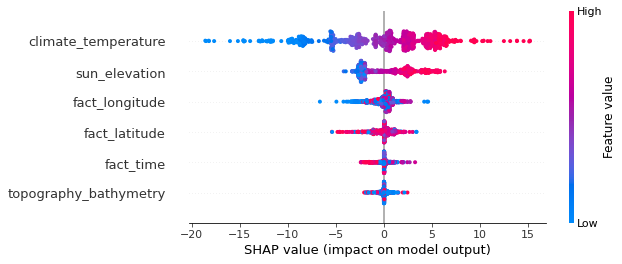

In [42]:
import shap
shap_values = shap.TreeExplainer(model_rf).shap_values(train_x[0:1000], approximate=True)
shap.summary_plot(shap_values, train_x[0:1000])

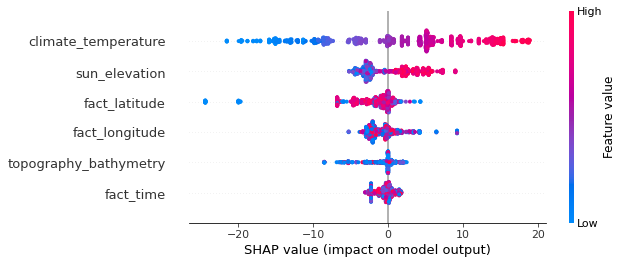

In [43]:
shap_values = shap.TreeExplainer(model_rf_q).shap_values(train_x[0:1000], approximate=True)
shap.summary_plot(shap_values, train_x[0:1000])

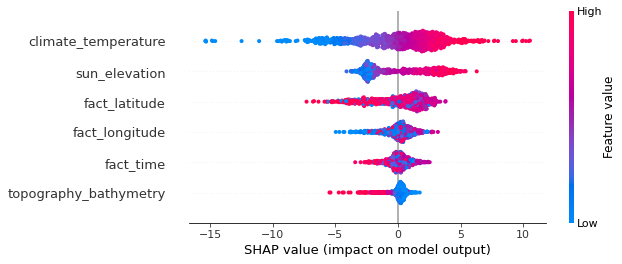

In [44]:
shap_values = shap.TreeExplainer(model_cbr).shap_values(train_x[0:1000])
shap.summary_plot(shap_values, train_x[0:1000])

Видим, что наиболее важны признаки climate_temperature, sun_elevation и fact_latitude

### Задание 10 (1.5 балл) 
В ролике Лена упоминала про ускорение за счет обучения моделей на разных географических регионах. 
Как первое приближение индикатора принадлежности к тому или иному региону попробуйте использовать имеющуюся категориальную переменную climate.

Удалось ли за счет этого увеличить качество?
Можно ли придумать что-то лучшее, чем разбиение по climate?

## Часть 2
Давайте теперь поставим задачу классификации.

<img src="./images/cwsm_classes.jpg">

In [45]:
train_2018_09.fact_cwsm_class.value_counts(dropna=False)

0.0     175257
10.0    148256
20.0     81576
11.0     13115
21.0     12004
23.0       170
13.0        36
22.0        16
12.0         6
Name: fact_cwsm_class, dtype: int64

In [46]:
(train_2018_09.fact_cwsm_class.astype("int8").isin([0,10,20])).value_counts(normalize=True)

True     0.941113
False    0.058887
Name: fact_cwsm_class, dtype: float64

In [47]:
0.941113 / 0.058887

15.981676770764345

In [48]:
(train_2018_10.fact_cwsm_class.astype("int8").isin([0,10,20])).value_counts(normalize=True)

True     0.93364
False    0.06636
Name: fact_cwsm_class, dtype: float64

Видно, что по объектам шанс 1 к 16, что будет дождь.

Сначала будем решать задачу бинарной классификации

Как будем оценивать эту задачу?
Раз у нас классы не сбалансированы, то, согласно, например https://ysda_trove.gitlab.io/ml-handbook/chapters/model_evaluation/intro, 
метрика accuracy/error_rate нам не подойдёт.

Давайте будем рассматривать
  * сбалансированную точность как основную метрику качества
  * Как вспомогательные
    * точность предсказания класса 1
    * полноту предсказания класса 1
    * F1-меру
  
Для начала порог отсечения при принятии решения к какому классу относится предскзаание будем брать 0.5

### Задание 11 (0.5 балла) 
 
Постройте baseline решения:
  
* Dummy Classifier 

* дерево решений

По валидационной выборке подберите лучшие параметры
    

*True - осадки, False - нет осадков*

In [49]:
train_x2 = train_2018_09[[
  'fact_time',
  'fact_latitude',
  'fact_longitude', 
  'topography_bathymetry',
  'sun_elevation',
  'climate_temperature'
]]
train_y2 = train_2018_09['fact_cwsm_class'].astype("int8").isin([0, 10, 20]) == False
test_x2 = train_2018_10[[
  'fact_time',
  'fact_latitude',
  'fact_longitude', 
  'topography_bathymetry',
  'sun_elevation',
  'climate_temperature'
]]
test_y2 = train_2018_10['fact_cwsm_class'].astype("int8").isin([0, 10, 20]) == False

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score

model_dc = DummyClassifier()
model_dc.fit(train_x2, train_y2)
pred_y2_dc = model_dc.predict(test_x2)

print((test_y2 == pred_y2_dc).value_counts(normalize=True)[True])
print(balanced_accuracy_score(test_y2, pred_y2_dc))

0.9336403045855435
0.5


In [51]:
from sklearn.tree import DecisionTreeClassifier
model_dtc = DecisionTreeClassifier()
model_dtc.fit(train_x2, train_y2)
pred_y2_dtc = model_dtc.predict(test_x2)

print((test_y2 == pred_y2_dtc).value_counts(normalize=True)[True])
print(balanced_accuracy_score(test_y2, pred_y2_dtc))

0.75835639770066
0.5144012288010941


### Задание 12 (3.5 балла) 
  * обучите RF-ERT на оригинальных признаках
  * обучите RF-ERT поверх бинаризации, которая была лучшей в задачи регрессии
  * обучите catboost
  * сравните качество по рассмотренным ранее метрикам (основной и дополнительным)
  * сравните важности принаков 
    * встроенными методами
    * при помщи пакета shap

*RF-ERT на оригинальных признаках*

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

model_rfc = RandomForestClassifier()
model_rfc.fit(train_x2, train_y2)
pred_y_rfc = model_rfc.predict(test_x2)
print(balanced_accuracy_score(test_y2, pred_y_rfc))

model_rtc = ExtraTreesClassifier()
model_rtc.fit(train_x2, train_y2)
pred_y_rtc = model_rtc.predict(test_x2)
print(balanced_accuracy_score(test_y2, pred_y_rtc))


0.5071566231230684
0.5072322763290861


*RF-ERT поверх квантизации, которая была лучшей в задачи регрессии*

In [53]:
model_rfc_q = RandomForestClassifier()
model_rfc_q.fit(train_x_digitized, train_y2)
pred_y_rfc_q = model_rfc_q.predict(test_x_digitized)
print(balanced_accuracy_score(test_y2, pred_y_rfc))

model_rtc_q = ExtraTreesClassifier()
model_rtc_q.fit(train_x_digitized, train_y2)
pred_y_rtc_q = model_rtc_q.predict(test_x_digitized)
print(balanced_accuracy_score(test_y2, pred_y_rtc))


0.5071566231230684
0.5072322763290861


*catboost*

In [63]:
from catboost import CatBoostClassifier

model_cbc = CatBoostClassifier()
model_cbc.fit(train_x2, train_y2, silent=True)
pred_y_cbc = model_cbc.predict(test_x2)
print(balanced_accuracy_score(test_y2, pred_y_cbc == 'True'))


0.50871139903327


Сбалансированная точность:  
RF: 0.508, ERT: 0.507  
RF: 0.508, ERT: 0.507  
CB: 0.509

*Важности признаков*

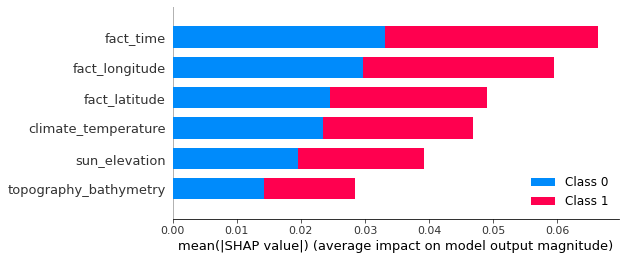

In [64]:
shap_values = shap.TreeExplainer(model_rfc).shap_values(train_x2[0:1000], approximate=True)
shap.summary_plot(shap_values, train_x2[0:1000])

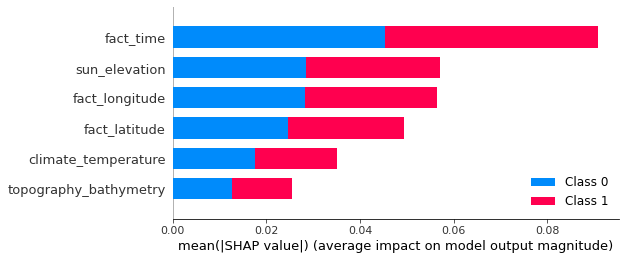

In [65]:
shap_values = shap.TreeExplainer(model_rfc_q).shap_values(train_x_digitized[0:1000], approximate=True)
shap.summary_plot(shap_values, train_x_digitized[0:1000])

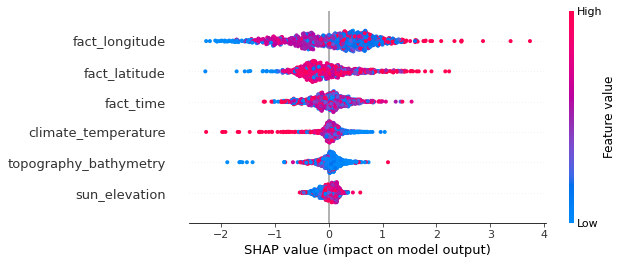

In [67]:
shap_values = shap.TreeExplainer(model_cbc).shap_values(train_x2[0:1000])
shap.summary_plot(shap_values, train_x2[0:1000])

### Задание 13. "Протухание модели" (0.5 балла) 
  
  Давайте узнаем, происходит ли устаревание ("протухание") модели. 
    
  Расмотрите, как модели из регрессионной и классификационной задач предсказывают на 2018_11, 2018_12 и 2019_01.
  
  Происходит ли деградация?

## Калибровка классификатора

Рассмотрим в задачу, где целевой метрикой является *logloss*. В этом случае необходимо, чтобы классификатор умел предсказывать вероятность принадлежности к классу. К сожалению, на практике часто получается так, что либо классификатор не обладает желаемым свойством (например, SVM без специальных настроек), либо метод *predict_proba* возвращает некорректную вероятность (например, случайный лес возвращает среднее арифметическое вероятностей от каждого дерева, которое не обязано являться корректной вероятностью, подробнее [здесь](http://people.dsv.su.se/~henke/papers/bostrom08b.pdf)).

В этом случае возможны несколько подходов: 
 - Заменить классификатор на тот, который умеет предсказывать вероятности.
 - Воспользоваться калибровкой ответов.
 
В общем случае первый подход не самый удачный выбор, так как накладывает ограничения на модели, которые можно использовать. Поэтому рассмотрим второй более подробно. По умолчанию SVM может вычислять отступ от заданного объекта до разделяющей гиперплоскости, а не возвращать вероятности. После чего можно обучить преобразование, которое искажает возвращаемое значение в вероятность  — это и называется **калибровкой**. Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Замечание: выше написано, что SVM по умолчанию не возвращает вероятности. Если же заглянуть в документацию [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), то можно найти параметр *probability*. Если установить его равным *True*, то у такого классификатора можно вызвать метод *predict_proba* и получить оценки вероятностей. В библиотеке реализована калибровка Платта и с классификатором проделывается примерно тоже самое, что было описано выше. Использование этого параметра замедляет процесс обучения, зато позволяет сразу же использовать данный классификатор для оценивания вероятностей. Обратите внимание, что у класса [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) такой опции нет.

### Задание 14 (0.5 балла) 
  Вспомним, что мы не подбирали порог, по которому классификаторы превращают оценку вероятности принадлежности к первому классу 
  
  Давайте оценим, насколько хорошо калиброваны наши классификаторы из Задания 11 на 2018_11
  
    
  ссылка на главу учебника
https://ysda_trove.gitlab.io/ml-handbook/chapters/prob_ML/calibration

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

https://dyakonov.org/2020/03/27/проблема-калибровки-уверенности/

### Задание 15 (2 балл) 

Давайте откалибруем классификаторы из задания 11 на 2018_10 и вновь посмотрим на качество их калибровки на 2018_11.

Построим кривые точность-полнота для класса 1 и класса 0 у некалиброванных и калиброванных моделей. Отличаются ли они?

Мы попробовали два типа ансамблей: случайный лес (бэггинг) и градиентный бустинг. Время что-нибудь настекать!


Описание того, как строить ансамбли типа стекинг можно найти по слудующим ссылкам
  * На лекции https://lk.yandexdataschool.ru/courses/2021-autumn/7.936-machine-learning-1/classes/7718/
  * В учебнике https://ysda_trove.gitlab.io/ml-handbook/chapters/ensembles/intro#стекинг
  * В статье https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/

### Задание 16 (3 балла) 
    
  Какие базовые модели можно использовать:
    * лучшие модели из задания 11
    * давайте обучим логистическую регрессию
    * по желанию, попробуйте нейросеть
    
  Попробуйте брать 2-3 разные базовые модели первого уровня, а в качестве модели второго уровня пропробуйте ERT и catboost.
    
  Весь ансабль должен быть обучен на 2018_09, т.е. нужно применять cross_val_predict.  
  Почему так следует делать, можно вспомнить, заглянув в соответствующий раздел учебника  
  https://ysda_trove.gitlab.io/ml-handbook/chapters/ensembles/intro